# MissionWired Data Engineer exercise
## Problem Statement
The task involves processing a simulated CRM dataset to produce two output files:
1. A `people` file with specific attributes.
2. An `acquisition_facts` file that aggregates statistics about when people in the dataset were acquired.

The dataset is provided through three public AWS S3 CSV files:
- Constituent Information
- Constituent Email Addresses
- Constituent Subscription Status

The objective is to merge these datasets, clean and transform the data as needed, and produce the required output files.

## Assumptions -
Following are the assumptions before completing the tasks
- Code column in people file comes from Source column in the constituent information file
- Person creation and person updated datetime come from create_dt and modified_dt from the constituent information file
- Rows where email is missing, but subscribed column is True, are also considered for aggregate


In [1]:
## install pandas and numpy

!pip install pandas
!pip install numpy


In [2]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)

## Dataset Loading

In this section, we load the datasets from the provided URLs. We selectively read the necessary columns to optimize memory usage and processing time.

In [3]:
# Load the constituent information dataset
url = "https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons.csv"
cols = ['cons_id', 'source', 'create_dt', 'modified_dt']
cons_info = pd.read_csv(url, usecols=cols)

In [4]:
# Load the constituent email addresses dataset
url = "https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email.csv"
cols = ['cons_id', 'cons_email_id', 'is_primary', 'email']
cons_email = pd.read_csv(url, usecols=cols)

# Filter to only include primary emails
cons_email = cons_email[cons_email.is_primary == 1]

In [5]:
# Load the constituent subscription status dataset
url = "https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email_chapter_subscription.csv"
cols = ['cons_email_id', 'chapter_id', 'isunsub']
cons_subs = pd.read_csv(url, usecols=cols)

# Filter for chapter_id = 1
cons_subs = cons_subs[cons_subs.chapter_id == 1]

### Lets observe the shape and column information for each dataset

In [6]:
print(cons_info.shape)
print(cons_info.columns)
cons_info.head(10)

(700000, 4)
Index(['cons_id', 'source', 'create_dt', 'modified_dt'], dtype='object')


,cons_id,source,create_dt,modified_dt
0,1,google,"Fri, 1983-08-26 06:02:03","Sun, 2015-12-27 09:28:02"
1,2,facebook,"Mon, 1979-03-05 21:08:54","Tue, 1989-06-20 13:28:57"
2,3,NaN,"Fri, 2008-08-22 19:20:28","Fri, 2020-06-05 18:13:57"
3,4,google,"Sun, 1984-04-29 11:18:18","Tue, 2012-01-31 07:26:35"
4,5,NaN,"Thu, 2007-07-19 18:28:09","Tue, 1971-04-27 06:53:53"
5,6,google,"Sat, 2014-02-15 22:54:27","Fri, 1999-11-12 06:09:25"
6,7,NaN,"Thu, 1979-03-01 16:12:55","Wed, 2019-03-13 02:52:10"
7,8,twitter,"Tue, 2002-07-30 22:28:38","Sat, 1983-07-16 18:30:07"
8,9,twitter,"Thu, 2019-08-29 14:50:24","Sun, 2009-12-20 14:50:14"
9,10,twitter,"Tue, 1987-02-17 11:22:04","Sat, 2016-03-19 17:33:38"


In [7]:
print(cons_email.shape)
print(cons_email.columns)
cons_email.head()

(605639, 4)
Index(['cons_email_id', 'cons_id', 'is_primary', 'email'], dtype='object')


,cons_email_id,cons_id,is_primary,email
0,1,548198,1,xmartinez@vincent.com
1,2,491137,1,hmiller@haynes.biz
2,3,413429,1,aaron64@yahoo.com
3,4,347346,1,wyattvincent@hotmail.com
4,5,443000,1,tspencer@hotmail.com


In [8]:
print(cons_subs.shape)
print(cons_subs.columns)
cons_subs.head()

(275484, 3)
Index(['cons_email_id', 'chapter_id', 'isunsub'], dtype='object')


,cons_email_id,chapter_id,isunsub
0,332188,1,1
1,536526,1,1
2,134711,1,1
3,660345,1,1
4,184268,1,1


# ---------- TASK 1 ----------

## Data Merging and Cleaning

In this section, we merge the datasets based on common identifiers (`cons_id` and `cons_email_id`) -
- To _combine source_, _create_dt_, and _modified_dt_ from cons_info dataframe with _email_ from cons_email dataframe
- Let's implement the _left join_ to ensure getting all the rows with _create_dt_ i.e. person creation time concerned, from the cons_info dataframe
- After this, lets implement _left join_ with the subscription cons_subs dataframe for the same reason

The merging is done in two stages to produce the final dataset for analysis


In [9]:
# Merge cons_info and cons_email on 'cons_id'
merge1 = pd.merge(cons_info, cons_email, on='cons_id', how='left')

# Merge the result with cons_subs on 'cons_email_id'
result = pd.merge(merge1, cons_subs, on='cons_email_id', how='left')

# Display the shape and column information of the merged dataset
print(result.shape)
print(result.columns)
result.head()

(700000, 9)
Index(['cons_id', 'source', 'create_dt', 'modified_dt', 'cons_email_id',
       'is_primary', 'email', 'chapter_id', 'isunsub'],
      dtype='object')


,cons_id,source,create_dt,modified_dt,cons_email_id,is_primary,email,chapter_id,isunsub
0,1,google,"Fri, 1983-08-26 06:02:03","Sun, 2015-12-27 09:28:02",546912.0,1.0,daniel72@hudson.com,NaN,NaN
1,2,facebook,"Mon, 1979-03-05 21:08:54","Tue, 1989-06-20 13:28:57",415587.0,1.0,caustin@spears-carson.com,1.0,1.0
2,3,NaN,"Fri, 2008-08-22 19:20:28","Fri, 2020-06-05 18:13:57",81594.0,1.0,klewis@ford.biz,1.0,1.0
3,4,google,"Sun, 1984-04-29 11:18:18","Tue, 2012-01-31 07:26:35",NaN,NaN,NaN,NaN,NaN
4,5,NaN,"Thu, 2007-07-19 18:28:09","Tue, 1971-04-27 06:53:53",182741.0,1.0,stephenhamilton@gmail.com,1.0,1.0


In [10]:
# Select the relevant columns for the final 'people' file
df = result[['email','source','isunsub','create_dt','modified_dt']]

# rename column names from source to code, isunsub to is_unsub, create_dt_x to created_dt, modified_dt_x to updated_dt
df = df.rename(columns={'source': 'code', 'isunsub': 'is_unsub', 'create_dt': 'created_dt', 'modified_dt': 'updated_dt'})

# Display the shape and first few rows of the final 'people' file
print(df.shape)
df.head()

(700000, 5)


,email,code,is_unsub,created_dt,updated_dt
0,daniel72@hudson.com,google,NaN,"Fri, 1983-08-26 06:02:03","Sun, 2015-12-27 09:28:02"
1,caustin@spears-carson.com,facebook,1.0,"Mon, 1979-03-05 21:08:54","Tue, 1989-06-20 13:28:57"
2,klewis@ford.biz,NaN,1.0,"Fri, 2008-08-22 19:20:28","Fri, 2020-06-05 18:13:57"
3,NaN,google,NaN,"Sun, 1984-04-29 11:18:18","Tue, 2012-01-31 07:26:35"
4,stephenhamilton@gmail.com,NaN,1.0,"Thu, 2007-07-19 18:28:09","Tue, 1971-04-27 06:53:53"


### Convert column formats according to the required schema, and save as a CSV file

In [11]:
# convert datetime columns to pandas datetime schema
df['created_dt'] = pd.to_datetime(df['created_dt'])
df['updated_dt'] = pd.to_datetime(df['updated_dt'])

# convert is_unsub column to boolean, if NaN found, assume subscribed i.e. False
df['is_unsub'] = df['is_unsub'].fillna(0).astype(bool)

In [12]:
# save df as a CSV with a header line to the working directory
df.to_csv('people.csv', index=False)

# ---------- TASK 2 ----------

Using the people.csv file, let's aggregate stats about when people in the dataset were acquired.

In [13]:
# read the people file
people_df = pd.read_csv('people.csv')

# Convert 'created_dt' to date type
people_df['created_dt'] = pd.to_datetime(people_df['created_dt']).dt.date

# Group by acquisition date and count the number of acquisitions
acquisition_facts = people_df.groupby('created_dt', dropna=False)['is_unsub'].count().reset_index()

# Rename the columns
acquisition_facts.columns = ['acquisition_date', 'acquisitions']

# sum of acquisitions match with the people dataset, ensuring no data loss
print(acquisition_facts.acquisitions.sum())

## print data_type of each column to match with required schema
print(acquisition_facts.info())

# Display the result
print(acquisition_facts.shape)
acquisition_facts.head()

700000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18445 entries, 0 to 18444
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   acquisition_date  18445 non-null  object
 1   acquisitions      18445 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 288.3+ KB
None
(18445, 2)


,acquisition_date,acquisitions
0,1970-01-01,34
1,1970-01-02,38
2,1970-01-03,32
3,1970-01-04,39
4,1970-01-05,44


In [14]:
# save to CSV in the working directory
acquisition_facts.to_csv('acquisition_facts.csv', index=False)

## Visualization

Lets visualize the data to observe the pattern of acquisitions. After data exploration -
- Removing outlier data for improved visual
- Limiting y axis between 13000 and 15000 to get a better visual

Date Transformation -
- The date fields in the dataset contain day-level information, which may not be necessary for this analysis. Therefore, we transform the data to retain only the year part, removing any specific time details.


In [15]:
## install matplotlib
!pip install matplotlib

In [16]:
## import packages
import matplotlib.pyplot as plt

In [17]:
# Extract year from acquisition_date
acquisition_facts['acquisition_year'] = pd.to_datetime(acquisition_facts['acquisition_date']).dt.year

# Group by acquisition year and sum the acquisitions
yearly_acquisitions = acquisition_facts.groupby('acquisition_year')['acquisitions'].sum().reset_index()

# Lets look at the interquartile range to remove outliers
# Calculate quartiles
q1 = yearly_acquisitions['acquisitions'].quantile(0.05)
q3 = yearly_acquisitions['acquisitions'].quantile(0.95)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter outliers
yearly_acquisitions_filtered = yearly_acquisitions[(yearly_acquisitions['acquisitions'] >= lower_bound) & (yearly_acquisitions['acquisitions'] <= upper_bound)]

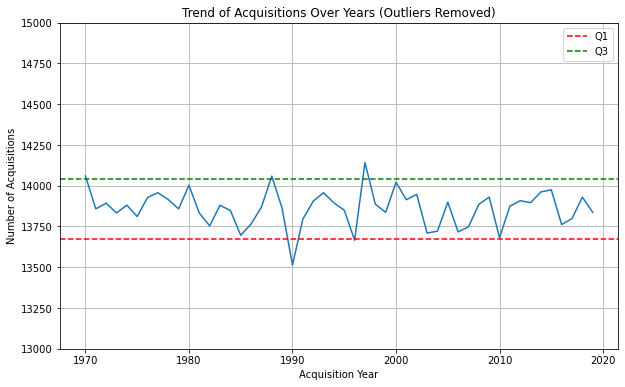

In [18]:
# Plot the trend
plt.figure(figsize=(10, 6))
plt.plot(yearly_acquisitions_filtered['acquisition_year'], yearly_acquisitions_filtered['acquisitions'])
plt.xlabel('Acquisition Year')
plt.ylabel('Number of Acquisitions')
plt.title('Trend of Acquisitions Over Years (Outliers Removed)')
plt.ylim(13000, 15000)  # Set y-axis limits for better visualization

# Add quartile information
plt.axhline(y=q1, color='r', linestyle='--', label='Q1')
plt.axhline(y=q3, color='g', linestyle='--', label='Q3')

plt.legend()
plt.grid(True)
plt.show()

## Conclusion -
The plotted graph shows us -
- Number of acquisitions have been consistent
- Ranging between <13750 , 14000> every year
- Lower bound and Upper bound of yearly acquisitions are close, proving consistency

# Approach 2 - Using PySpark
In this approach, let's utilize PySpark to perform the same operations as done with Pandas. PySpark is particularly beneficial when dealing with large datasets, as it allows distributed computing and can handle big data efficiently.

Let's explore the same tasks using PySpark with the same assumptions.
- Naming of variables and output files will be different, to avoid overwriting

In [19]:
## install pyspark
!pip install pyspark

In [20]:
## import required packages
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.functions import col, substring, to_date, count, year

from pyspark.sql.types import BooleanType, StringType, DateType

In [21]:
# Initialize SparkSession
spark = SparkSession.builder.appName("MissionWired").getOrCreate()

# Load the constituent information dataset; select only necessary columns

url_2 = "https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons.csv"
cols_2 = ['cons_id', 'source', 'create_dt', 'modified_dt']

## add url file to spark context to read it locally
spark.sparkContext.addFile(url_2)
cons_info_2 = spark.read.csv(SparkFiles.get(url_2.split('/')[-1]), header=True, inferSchema=True).select(cols_2)

# Load the constituent email addresses dataset
url_2 = "https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email.csv"
cols_2 = ['cons_id', 'cons_email_id', 'is_primary', 'email']

spark.sparkContext.addFile(url_2)
cons_email_2 = spark.read.csv(SparkFiles.get(url_2.split('/')[-1]), header=True, inferSchema=True).select(cols_2).filter(col("is_primary") == 1)

# Load the constituent subscription status dataset
url_2 = "https://als-hiring.s3.amazonaws.com/fake_data/2020-07-01_17%3A11%3A00/cons_email_chapter_subscription.csv"
cols_2 = ['cons_email_id', 'chapter_id', 'isunsub']

spark.sparkContext.addFile(url_2)
cons_subs_2 = spark.read.csv(SparkFiles.get(url_2.split('/')[-1]), header=True, inferSchema=True).select(cols_2).filter(col("chapter_id") == 1)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


24/08/23 00:02:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## ---------- TASK 1 ----------

### Merging Datasets on `cons_id` and `cons_email_id`
In this step, merging the `cons_info` and `cons_email` datasets using the `cons_id` field. This operation is similar to a SQL `LEFT JOIN`. We then merge the resulting dataset with the `cons_subs` dataset on the `cons_email_id` field. The merging ensures that we consolidate all relevant data into a single DataFrame for further processing.


In [22]:
# Merge cons_info and cons_email on 'cons_id'
merge1_2 = cons_info_2.join(cons_email_2, "cons_id", "left")

# Merge the result with cons_subs on 'cons_email_id'
result_2 = merge1_2.join(cons_subs_2, "cons_email_id", "left")

# Select the relevant columns for the final 'people' file
people_df_2 = result_2.select(col("email"), col("source").alias("code"),
                         col("isunsub").alias("is_unsub"),
                         col("create_dt").alias("created_dt"),
                         col("modified_dt").alias("updated_dt"))

# Fill missing 'is_unsub' values with False (assuming subscribed)
people_df_2 = people_df_2.fillna(False, subset=["is_unsub"])

# Cast 'is_unsub' to BooleanType and fill nulls with False
people_df_2 = people_df_2.withColumn("is_unsub", col("is_unsub").cast(BooleanType())) \
    .fillna(False, subset=["is_unsub"])

# Cast 'email' and 'code' to StringType
people_df_2 = people_df_2.withColumn("email", col("email").cast(StringType())) \
    .withColumn("code", col("code").cast(StringType()))

# Remove day information to convert to datetime
people_df_2 = people_df_2.withColumn("created_dt", to_date(substring("created_dt", 6, 10), "yyyy-MM-dd")) \
    .withColumn("updated_dt", to_date(substring("updated_dt", 6, 10), "yyyy-MM-dd"))

# Save 'people' DataFrame as a CSV file
# people_df_2.write.csv("people_2.csv", header=True, mode="overwrite")

## bypassing to pandas for now to save as one file; pyspark saves as partitioned files
people_df_2.toPandas().to_csv('people_2.csv',index=False)

## ---------- TASK 2 ----------
### Generating the `acquisition_facts_2` File

In this section, we load the previously saved `people_2` DataFrame from the CSV file. We then process the `created_dt` column to ensure it is in the correct date format. The data is grouped by acquisition date to count the number of acquisitions per date. Finally, the resulting DataFrame is saved as `acquisition_facts_2.csv`.


In [23]:
# Load the 'people' DataFrame from the CSV file
people_df_2 = spark.read.csv("people_2.csv", header=True, inferSchema=True)

# Convert 'created_dt' to date type
people_df_2 = people_df_2.withColumn("created_dt", to_date(col("created_dt")))

# Group by acquisition date and count the number of acquisitions
acquisition_facts_2 = people_df_2.groupBy("created_dt").agg(count("*").alias("acquisitions")) \
    .withColumnRenamed("created_dt", "acquisition_date") \
    .orderBy("acquisition_date")

# convert acquisitions column to int
acquisition_facts_2 = acquisition_facts_2.withColumn("acquisitions", col("acquisitions").cast("int"))

# save the output as csv
# acquisition_facts_2.write.csv("acquisition_facts_2.csv", header=True, mode="overwrite")

## bypassing to pandas for now to save as one file; pyspark saves as partitioned files
acquisition_facts_2.toPandas().to_csv('acquisition_facts_2.csv',index=False)

### Assignment Summary

This assignment was a rewarding and enjoyable process that allowed me to demonstrate my data engineering skills using both Pandas and PySpark. Working through the task of merging, transforming, and analyzing a simulated CRM dataset was not only a great way to apply my technical knowledge, but it also reinforced the importance of efficient data processing and documentation.


In addition to the original requirements, I took the initiatives to  -
- Utilize PySpark, aligning with the production standards mentioned, and showcasing my ability to work with big data tools.
- Incorporated data visualization and analysis, providing insights into the dataset and highlighted potential trends.


_I am excited for the next steps in the process and look forward to further opportunities to contribute my skills and knowledge._
